# Artifact Visualisation

In this notebook, we want to prove artifact creation induced by deconvolution layers. For this purpose, we decide to investigate the architecture of Encodec, an audio codec developed by Meta that features a neural network architecture with multiple deconvolution layers. 

Our hypothesis is that we can extrapolate our results on deconvolution layers in Encodec to any deconvolution layer.

In [55]:
import numpy as np
import torchaudio
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
from encodec import EncodecModel   # `pip install encodec` if unavailable

model = EncodecModel.encodec_model_48khz()  # will download and cache the weights when run for the first time

In [57]:
stft_transformer = torchaudio.transforms.Spectrogram(n_fft=1<<13, power=2)
def compute_fp_stft(p):
    stft = stft_transformer(torch.Tensor(p)).numpy()
    stft = 10 * np.log10( np.clip( stft, 1e-10, 1e6 ) )
    fingerprint = np.mean( stft, axis=(2) ) 
    return fingerprint

In [ ]:

audio_path = "../data/ai/fake_00001_suno_0.mp3"
audio, sr = torchaudio.load(audio_path, channels_first = False) # Return tensor and sample rate
audio = torch.Tensor(audio.T)
if len(audio) == 1: # mono to stereo
    audio = torch.cat([audio, audio], dim=0)  
    print("Converted mono to stereo by duplicating the channel.")
audio = audio.unsqueeze(0) # Requires audio to be stereo, mono not supported.
frames = model.encode(audio)
fft_audio_input = compute_fp_stft(audio[0])

# we ignore the output scaling and linear interpolation between frames (1 sec audio) and directly decode everything
codes = torch.concatenate([a[0] for a in frames], -1)
with torch.no_grad():
    emb = model.quantizer.decode(codes.transpose(0, 1))
    post_lstm = model.decoder.model[:2](emb)

audio_latent = post_lstm

Converted mono to stereo by duplicating the channel.


In [70]:
audio_latent.shape

torch.Size([1, 512, 11313])

In [71]:
input_fft = compute_fp_stft(audio_latent[0])

ffts = []
with torch.no_grad():
    for l in [4, 7, 10, 13]: # layers of deconvs
        latent = model.decoder.model[2:l](audio_latent)
        fft_latent = compute_fp_stft(latent[0])
        ffts.append(fft_latent)

with torch.no_grad():
    audio_rec = model.decoder.model[2:](audio_latent)
output_fft = compute_fp_stft(audio_rec[0])

In [72]:
model.decoder.model

Sequential(
  (0): SConv1d(
    (conv): NormConv1d(
      (conv): Conv1d(128, 512, kernel_size=(7,), stride=(1,))
      (norm): GroupNorm(1, 512, eps=1e-05, affine=True)
    )
  )
  (1): SLSTM(
    (lstm): LSTM(512, 512, num_layers=2)
  )
  (2): ELU(alpha=1.0)
  (3): SConvTranspose1d(
    (convtr): NormConvTranspose1d(
      (convtr): ConvTranspose1d(512, 256, kernel_size=(16,), stride=(8,))
      (norm): GroupNorm(1, 256, eps=1e-05, affine=True)
    )
  )
  (4): SEANetResnetBlock(
    (block): Sequential(
      (0): ELU(alpha=1.0)
      (1): SConv1d(
        (conv): NormConv1d(
          (conv): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
          (norm): GroupNorm(1, 128, eps=1e-05, affine=True)
        )
      )
      (2): ELU(alpha=1.0)
      (3): SConv1d(
        (conv): NormConv1d(
          (conv): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
          (norm): GroupNorm(1, 256, eps=1e-05, affine=True)
        )
      )
    )
    (shortcut): SConv1d(
      (conv): NormCon

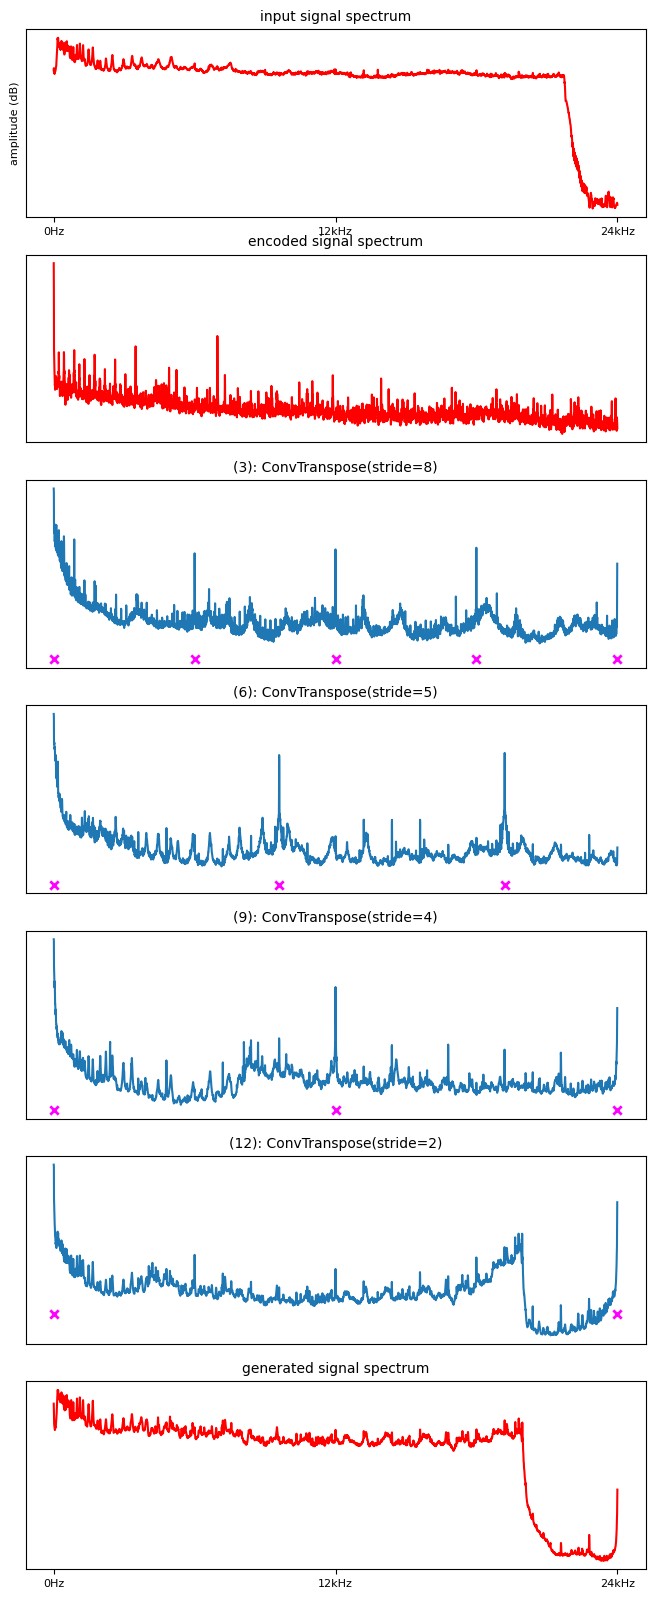

In [73]:
def plot_fractal(k=8, N=4097, y_offset=0):
    """ Display where the peaks are supposed to be. """
    x = []
    y = []
    for t in range(0, k//2+1):
        x.append(t*2*N/k)
        y.append(y_offset)
    plt.scatter(x, y, c="magenta", marker="x", linewidth=2, clip_on=False)

plt.figure(figsize=(8, 20))
plt.subplot(7, 1, 1)
plt.plot(np.mean(fft_audio_input, 0), color="red")
plt.title("input signal spectrum", fontsize=10)
plt.xticks([0, 2048, 4096], ["0Hz", "12kHz", "24kHz"], fontsize=8)
plt.yticks([], [])
plt.ylabel("amplitude (dB)", fontsize=8)

plt.subplot(7, 1, 2)
plt.plot(np.mean(input_fft, 0), color="red")
plt.title("encoded signal spectrum", fontsize=10)
plt.xticks([], [])  # the x-axis doesn't really make sense here
plt.yticks([], [])

plt.subplot(7, 1, 3)
plt.plot(np.mean(ffts[0], 0))
plt.title("(3): ConvTranspose(stride=8)", fontsize=10)
plt.xticks([], [])  # the x-axis doesn't really make sense here
plt.yticks([], [])
plot_fractal(k=8, y_offset=np.mean(ffts[0])-8)

plt.subplot(7, 1, 4)
plt.plot(np.mean(ffts[1], 0))
plt.title("(6): ConvTranspose(stride=5)", fontsize=10)
plt.xticks([], [])  # the x-axis doesn't really make sense here
plt.yticks([], [])
plot_fractal(k=5, y_offset=np.mean(ffts[1])-8)

plt.subplot(7, 1, 5)
plt.plot(np.mean(ffts[2], 0))
plt.title("(9): ConvTranspose(stride=4)", fontsize=10)
plt.xticks([], [])  # the x-axis doesn't really make sense here
plt.yticks([], [])
plot_fractal(k=4, y_offset=np.mean(ffts[2])-8)

plt.subplot(7, 1, 6)
plt.plot(np.mean(ffts[3], 0))
plt.title("(12): ConvTranspose(stride=2)", fontsize=10)
plt.xticks([], [])  # the x-axis doesn't really make sense here
plt.yticks([], [])
plot_fractal(k=2, y_offset=np.mean(ffts[3])-8)

plt.subplot(7, 1, 7)
plt.plot(np.mean(output_fft, 0), label="output", color="red")
plt.title("generated signal spectrum", fontsize=10)

plt.xticks(fontsize=10)
plt.yticks([], [])
plt.xticks([0, 2048, 4096], ["0Hz", "12kHz", "24kHz"], fontsize=8)
plt.show()